# Домашнее задание 4 

### Выберите любой датасет с картинками с kaggle (можно собрать свой!) и обучите на нем свертку-классификатор.

Я увидела датасет с покемонами, захотелось https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types/data

In [1]:
!pip install torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 18.1 MB/s eta 0:00:00


In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

from torchmetrics import Accuracy as VAccuracy
from tqdm import tqdm
import random

import pandas as pd
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder

In [128]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
!pip install kaggle
import json
token = {"username":"arinasolomentseva","key":"c1046d81b159df5cc61a44d4546f7103"}

with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/kaggle.json ~/.kaggle/kaggle.json

!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

!unzip \*.zip

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/3.68M [00:00<?, ?B/s]
100% 3.68M/3.68M [00:00<00:00, 165MB/s]
Archive:  pokemon-images-and-types.zip
  

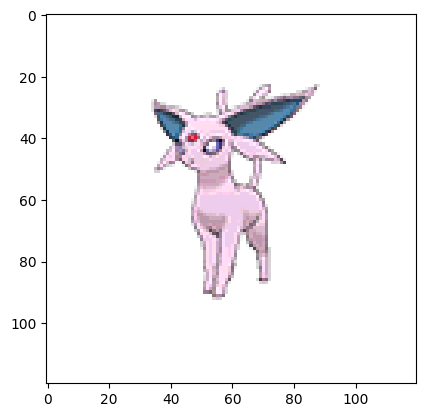

In [136]:
img4 = Image.open('images/espeon.png')
plt.imshow(img4)
plt.show()

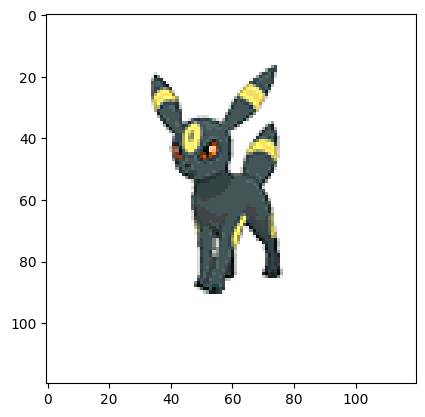

In [137]:
img = Image.open('images/umbreon.png')
plt.imshow(img)
plt.show()

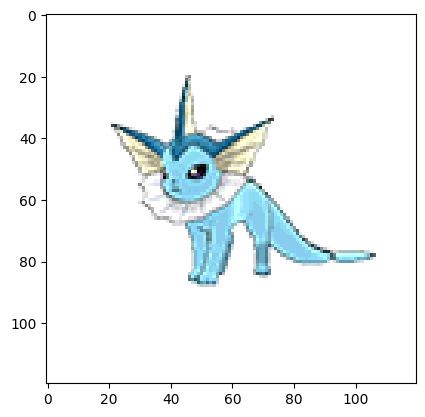

In [140]:
img = Image.open('images/vaporeon.png')
plt.imshow(img)
plt.show()

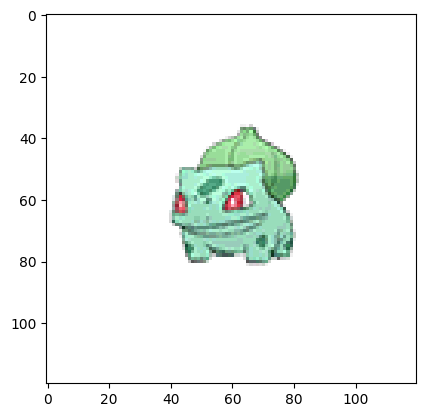

In [141]:
img2 = Image.open('images/bulbasaur.png')
plt.imshow(img2)
plt.show()

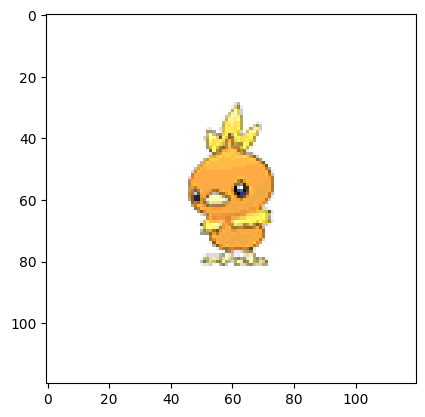

In [142]:
img3 = Image.open('images/torchic.png')
plt.imshow(img3)
plt.show()

In [143]:
data = pd.read_csv('pokemon.csv')
data

,Name,Type1,Type2,Evolution
0,bulbasaur,Grass,Poison,ivysaur
1,ivysaur,Grass,Poison,venusaur
2,venusaur,Grass,Poison,NaN
3,charmander,Fire,NaN,charmeleon
4,charmeleon,Fire,NaN,charizard
...,...,...,...,...
804,stakataka,Rock,Steel,NaN
805,blacephalon,Fire,Ghost,NaN
806,zeraora,Electric,NaN,NaN
807,meltan,Steel,NaN,NaN


In [144]:
data.value_counts('Type1') # возьму 5 самых больших

,count
Type1,
Water,114
Normal,105
Grass,78
Bug,72
Psychic,53
Fire,53
Rock,46
Electric,40
Poison,34


In [145]:
data.value_counts('Type2') # тут и данных меньше, и они ещё все в сочетании с прошлым типом, так что пока без типа 2...

,count
Type2,
Flying,95
Ground,32
Poison,32
Fairy,29
Psychic,29
Fighting,25
Steel,23
Grass,19
Dragon,18


In [146]:
image_df = []

path_start = 'images'

for filename in os.listdir(path_start):
    if filename.endswith('.png'):
        image_name = filename.split('.')[0]

        image = Image.open(os.path.join(path_start, filename))
        image = image.convert('RGB')  # на всякий случай
        image_array = np.array(image)
        image_df.append({'Name': image_name, 'img': image_array})

image_df = pd.DataFrame(image_df)

# соединяю с данными в csv
data = data.merge(image_df, how='inner', on='Name')

In [147]:
data.img.info()

<class 'pandas.core.series.Series'>
RangeIndex: 809 entries, 0 to 808
Series name: img
Non-Null Count  Dtype 
--------------  ----- 
809 non-null    object
dtypes: object(1)
memory usage: 6.4+ KB


In [148]:
data.loc[0].img.shape

(120, 120, 3)

In [150]:
data = data[data.Type1.isin(['Water', 'Normal', 'Grass', 'Bug', 'Psychic'])][['Name','Type1']] # 'Rock', 'Electric' 'Fire'

In [151]:
data.head(10)

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
6,squirtle,Water
7,wartortle,Water
8,blastoise,Water
9,caterpie,Bug
10,metapod,Bug
11,butterfree,Bug
12,weedle,Bug


In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422 entries, 0 to 799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    422 non-null    object
 1   Type1   422 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


In [153]:
data.Type1.unique()

array(['Grass', 'Water', 'Bug', 'Normal', 'Psychic'], dtype=object)

In [154]:
data.value_counts('Type1') # поймаем ой то есть предскажем их всех

,count
Type1,
Water,114
Normal,105
Grass,78
Bug,72
Psychic,53


In [155]:
data.columns

Index(['Name', 'Type1'], dtype='object')

In [156]:
le = LabelEncoder()

In [157]:
data['TypeNumeric'] = le.fit_transform(data['Type1'])

In [158]:
image_dir = '/content/images'

data['img'] = data['Name'].apply(lambda name: os.path.join(image_dir, f'{name}.png')) # у меня были проблемы, некоторые файлы не находились, поэтому ещё раз добавляю пути

In [159]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [160]:
class PokemonDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.labels = dataframe['TypeNumeric'].values
        self.image_paths = dataframe['img'].values
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = Image.open(image_path).convert('RGB')

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, label_tensor


In [161]:
pokeset = PokemonDataset(data, transform=transform)


In [162]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(pokeset, [0.70, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

In [163]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [86]:
def get_mean_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [92]:
mean, std = get_mean_std(train_dataloader)
print(mean, std)

tensor([-0.8080, -0.8174, -0.8372]) tensor([0.5052, 0.4780, 0.4398])


In [90]:
mean, std = get_mean_std(val_dataloader)
print(mean, std)

tensor([-0.7972, -0.8120, -0.8278]) tensor([0.5193, 0.4781, 0.4534])


In [91]:
mean, std = get_mean_std(test_dataloader)
print(mean, std)

tensor([-0.8087, -0.8112, -0.8298]) tensor([0.4980, 0.4846, 0.4525])


In [174]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(1, n_epochs + 1):
        # train
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train) # используем кросс-энтропию
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # validation
        if epoch % 1 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f"Epoch: {epoch}\tloss: {np.mean(val_loss)}\taccuracy: {np.mean(val_accuracy)}")

In [238]:
class PokemonCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(27 * 27 * 20, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16, 10, 58, 58
        x = self.pool(F.relu(self.conv2(x)))  # 16, 20, 27, 27
        x = self.flatten(x)                    # 16, 14580
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [249]:
set_random_seed(42)
pokemoncnn = PokemonCNN()
optimizer = optim.Adam(pokemoncnn.parameters(), lr=0.002, weight_decay=0.05)

In [250]:
train(pokemoncnn, optimizer, 10)

100%|██████████| 4/4 [00:00<00:00, 18.47it/s]


Epoch: 1	loss: 1.6069591045379639	accuracy: 0.2222222222222222


100%|██████████| 4/4 [00:00<00:00, 18.56it/s]


Epoch: 2	loss: 1.604132890701294	accuracy: 0.2222222222222222


100%|██████████| 4/4 [00:00<00:00, 13.27it/s]


Epoch: 3	loss: 1.6214303970336914	accuracy: 0.20634920634920634


100%|██████████| 4/4 [00:00<00:00, 19.70it/s]


Epoch: 4	loss: 1.624755620956421	accuracy: 0.25396825396825395


100%|██████████| 4/4 [00:00<00:00, 18.67it/s]


Epoch: 5	loss: 1.591033935546875	accuracy: 0.31746031746031744


100%|██████████| 4/4 [00:00<00:00, 13.54it/s]


Epoch: 6	loss: 1.5983505249023438	accuracy: 0.3333333333333333


100%|██████████| 4/4 [00:00<00:00, 18.91it/s]


Epoch: 7	loss: 1.5548535585403442	accuracy: 0.31746031746031744


100%|██████████| 4/4 [00:00<00:00, 20.55it/s]


Epoch: 8	loss: 1.6380763053894043	accuracy: 0.3492063492063492


100%|██████████| 4/4 [00:00<00:00, 19.57it/s]


Epoch: 9	loss: 1.549665927886963	accuracy: 0.3333333333333333


100%|██████████| 4/4 [00:00<00:00, 20.41it/s]


Epoch: 10	loss: 1.6167476177215576	accuracy: 0.3492063492063492


In [251]:
pokemoncnn.eval()

accuracy_metric = VAccuracy(task='multiclass', num_classes=5)

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs
        labels = labels

        outputs = pokemoncnn(inputs)
        _, preds = torch.max(outputs, 1)

        accuracy_metric.update(preds, labels)

accuracy = accuracy_metric.compute()
print(f'Accuracy: {accuracy}') #

Accuracy: 0.4285714328289032


In [252]:
# тут немного экспериментирую с моделью
class PokemonCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)

        self.pool = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

        self.dropout = nn.Dropout(0.1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(self.batch_norm1(F.relu(self.conv1(x))))
        x = self.pool(self.batch_norm2(F.relu(self.conv2(x))))
        x = self.pool(self.batch_norm3(F.relu(self.conv3(x))))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [272]:
set_random_seed(42)
pokemoncnn1 = PokemonCNN1()
optimizer = optim.SGD(pokemoncnn1.parameters(), lr=0.002, weight_decay=0.05)

In [273]:
train(pokemoncnn1, optimizer, 14)

100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch: 1	loss: 1.5998988151550293	accuracy: 0.20634920634920634


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch: 2	loss: 1.5881991386413574	accuracy: 0.25396825396825395


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch: 3	loss: 1.5539343357086182	accuracy: 0.30158730158730157


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 4	loss: 1.5816022157669067	accuracy: 0.31746031746031744


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


Epoch: 5	loss: 1.569042444229126	accuracy: 0.30158730158730157


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch: 6	loss: 1.5858105421066284	accuracy: 0.31746031746031744


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch: 7	loss: 1.569671869277954	accuracy: 0.30158730158730157


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Epoch: 8	loss: 1.5777467489242554	accuracy: 0.2698412698412698


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch: 9	loss: 1.587205410003662	accuracy: 0.3492063492063492


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch: 10	loss: 1.5661511421203613	accuracy: 0.30158730158730157


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch: 11	loss: 1.5866895914077759	accuracy: 0.3333333333333333


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch: 12	loss: 1.6558599472045898	accuracy: 0.36507936507936506


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch: 13	loss: 1.5965946912765503	accuracy: 0.3492063492063492


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

Epoch: 14	loss: 1.6338388919830322	accuracy: 0.2857142857142857


In [274]:
pokemoncnn1.eval()

accuracy_metric = VAccuracy(task='multiclass', num_classes=5)

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs
        labels = labels

        outputs = pokemoncnn1(inputs)
        _, preds = torch.max(outputs, 1)

        accuracy_metric.update(preds, labels)

accuracy = accuracy_metric.compute()
print(f'Accuracy: {accuracy}')

Accuracy: 0.5396825671195984


Половину где-то предсказали! Я думаю, я выбрала достаточно маленький датасет, возможно, тут стоило с помощью аугментации увеличить в два раза хотя бы те 5 типов